In [59]:
import sys
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [60]:
from coco.job import Job

In [61]:
current_job = Job.from_name("f3d_depth_spatial_limited")

state_run
phase_val
40


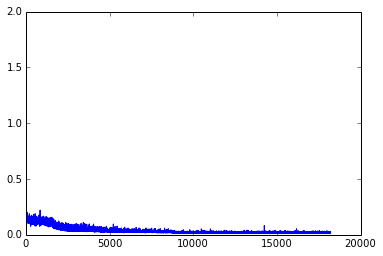

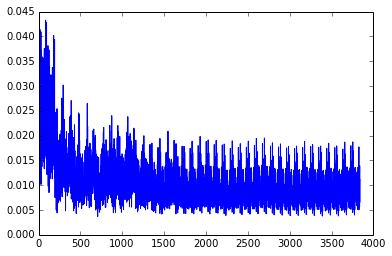

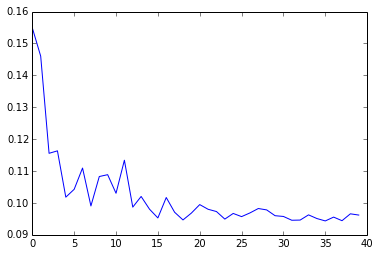

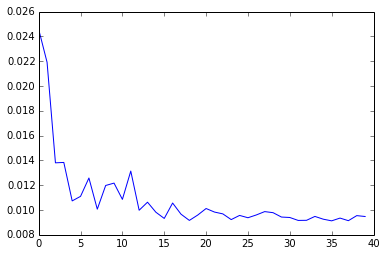

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Refresh job
current_job.load()
data = current_job.data

print data["state"]
print data["phase"]
print data["epoch"]

if "train_losses" in data:
    train_losses = np.array(data["train_losses"]).squeeze()
    plt.plot(train_losses[:])
    plt.show()

if "val_losses" in data:
    val_losses = np.array(data["val_losses"]).squeeze()
    plt.plot(val_losses)
    plt.show()

    w = 96
    l = []
    for i in range(0,len(val_losses),w):
        l.append((np.sqrt(val_losses)[i:i+w].mean()))
    plt.plot(l)  
    plt.show()
    l = []
    for i in range(0,len(val_losses),w):
        l.append(((val_losses)[i:i+w].mean()))

    plt.plot(l)
    plt.show()

In [63]:
import sys
import os
import inspect

import numpy as np

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from coco.database_reader import HDF5DatabaseReader
from coco.multiprocess import MultiProcessor
from coco.architectures.depth import DepthPredictionScaffolder, ResidualDepth
from coco.transformations import zoom_rotate, random_rgb, random_crop, normalize_images, downsample, clip, noise, exp

global mean
mean = np.load("/data/food3d/f3d-train.npy")

def process_train(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]

    size = (228, 304)
    
    global mean
    images, labels = exp(images, labels)
    images, labels = zoom_rotate(images, labels)
    images, labels = random_rgb(images, labels)
    images, labels = noise(images, labels)
    images, labels = clip(images, labels, ic=(0. ,255.))
    
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    
    images, labels = random_crop(images, labels, size)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

def process_val(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

train_db = "/data/food3d/f3d-train.hdf5"
val_db = "/data/food3d/f3d-val.hdf5"

batch_size = 16

train_reader = HDF5DatabaseReader(label_key="depths")
train_reader.setup_read(train_db)

val_reader = HDF5DatabaseReader(label_key="depths")
val_reader.setup_read(val_db)

train_processor = MultiProcessor(
    train_reader, func=process_train, batch_size=batch_size)
val_processor = MultiProcessor(
    val_reader, func=process_val, batch_size=batch_size)

scaffolder = DepthPredictionScaffolder(ResidualDepth, inference=True)

scaffolder.compile()
scaffolder.load("/data/data/resunet_f3d_spatial_limited.npz")

DEBUG:coco.multiprocess:Creating multiprocessor instance with batchsize=16 and queue_size=20
DEBUG:coco.multiprocess:Creating multiprocessor instance with batchsize=16 and queue_size=20
DEBUG:coco.nn:Number of parameters for output 'None': 59087105
INFO:coco.nn:Compiling inference function.
INFO:coco.nn:Loading parameters from file '/data/data/resunet_f3d_spatial_limited.npz'


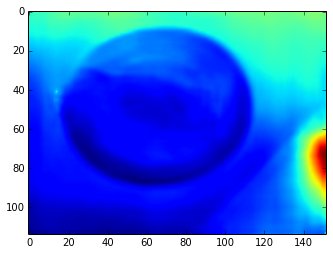

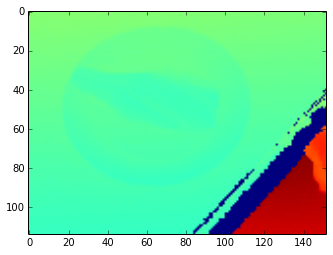

0.150842


In [75]:
m = []
for batch in val_processor.iterate():
    images, depths = batch
    idx = 7
    predictions = scaffolder.infer(images[idx][np.newaxis,:,:,:])[0].squeeze()
    depths = depths.squeeze()
    
    plt.imshow(predictions)
    plt.show()
    plt.imshow(depths[idx])
    plt.show()
    
    d = predictions - depths[idx]
    d[depths[idx] > 1.2] = 0
    mse = (d**2).mean()
    m.append(mse)
    break

print np.sqrt(np.array(m).mean())

In [293]:
from scipy.ndimage.interpolation import zoom
indices = range(0,100)
r = []
f = h5py.File("/data/data/test_v2.hdf5")
images = np.array(f["images"][:])
depths = np.array(f["depths"][:])

processed = process_val(images, depths)
residuals = []
scales = []


def remove_outliers(prediction):
    for y in range(prediction.shape[0]):
        for x in range(prediction.shape[1]):
            if prediction[y,x] > 12.:
                interp = 0.25 * (prediction[y+1,x] + prediction[y-1,x] + prediction[y,x+1] + prediction[y,x - 1])
                prediction[y,x] = interp
    return prediction

for i in range(processed[0].shape[0]):
    images = processed[0][i]
    depth = depths[i][6:234,8:312]
    # depth = processed[1][i]
    prediction = scaffolder.infer(images[np.newaxis,:,:,:])[0].squeeze()
    
    prediction = remove_outliers(prediction)
    
    prediction = zoom(prediction, 2, order=3)
    
    
    d = prediction.squeeze() - depth
    
    residuals.append(d)
    scales.append(depth / prediction)
    
    d[depth == 0] = 0
    mse = (d**2).mean()
    r.append(mse)
    
print np.sqrt(np.array(r).mean())

0.655895
